## Old T- tests
" please not that only models with New keyword foldername or filname are presented, we are keeping the code for previously trained models also" 

#### Re-usable Functions

This contains all the fucntions used to calculate metrics

In [4]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import torch
from skimage import measure
from scipy.ndimage import morphology

# Function to calculate OSR (Overlap-to-Signal Ratio)
# def overlap_signal_ratio(y_true, y_pred, smooth=1):
#     y_pred_labels = (y_pred >= 0.5).float()
#     intersection = torch.sum(y_true * y_pred_labels)
#     signal = torch.sum(y_true)
#     osr = (intersection + smooth) / (signal + smooth)
#     return osr

# Function to calculate USR (Under-Segmentation Rate)
def under_segmentation_rate(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    y_true_labels = (y_true >= 0.5).float()
    false_neg = torch.sum(y_true_labels * (1 - y_pred_labels))
    true_pos = torch.sum(y_true_labels * y_pred_labels)
    ground_truth_area = torch.sum(y_true_labels)
    prediction_area = torch.sum(y_pred_labels)
    usr = (false_neg + smooth) / (ground_truth_area + prediction_area + smooth)
    return usr

# Function to calculate ASD (Average Surface Distance)

import torch.nn.functional as F

def bce_loss(y_true, y_pred):
    # Ensure y_true and y_pred have the same shape
    return F.binary_cross_entropy(y_pred, y_true)

# Function to calculate ASD (Average Surface Distance)
def over_segmentation_ratio(y_true, y_pred, smooth=1e-5):
    y_pred_labels = (y_pred >= 0.5).float()
    y_true_labels = (y_true >= 0.5).float()
    false_positives = torch.sum((y_pred_labels == 1) & (y_true_labels == 0))
    ground_truth_area = torch.sum(y_true_labels)
    prediction_area = torch.sum(y_pred_labels)
    osr = (false_positives + smooth) / (ground_truth_area + prediction_area + smooth)
    return osr


import numpy as np
from scipy.ndimage import morphology

def average_surface_distance(y_true, y_pred, spacing=None):
    """
    Computes the Average Surface Distance (ASD) between the predicted and true binary masks.
    
    Parameters:
    - y_true (torch.Tensor): Ground truth binary mask.
    - y_pred (torch.Tensor): Predicted binary mask.
    - spacing (tuple or list): Voxel spacing for each dimension (optional). This accounts for anisotropic voxel sizes.
    
    Returns:
    - float: Average Surface Distance (ASD) between the surfaces of the ground truth and predicted masks.
    """
    
    # Convert tensors to numpy arrays and ensure boolean type
    y_true_np = y_true.detach().cpu().numpy().astype(np.bool_)
    y_pred_np = y_pred.detach().cpu().numpy().astype(np.bool_)
    
    # Define connectivity for finding surface voxels
    conn = morphology.generate_binary_structure(y_true_np.ndim, 1)
    
    # Surface voxels: Logical XOR between the binary mask and its eroded version
    true_surface = np.logical_xor(y_true_np, morphology.binary_erosion(y_true_np, conn))
    pred_surface = np.logical_xor(y_pred_np, morphology.binary_erosion(y_pred_np, conn))
    
    # Check for empty surfaces (in case of no object in the segmentation)
    if np.sum(true_surface) == 0 or np.sum(pred_surface) == 0:
        return float('inf')
    
    # Compute the Euclidean distance transform from the surface
    true_distances = morphology.distance_transform_edt(~true_surface, sampling=spacing)
    pred_distances = morphology.distance_transform_edt(~pred_surface, sampling=spacing)
    
    # Measure distances from one surface to the other
    dist_pred_to_true = np.mean(true_distances[pred_surface != 0])
    dist_true_to_pred = np.mean(pred_distances[true_surface != 0])
    
    # Calculate ASD as the mean of the two distances
    asd = (dist_pred_to_true + dist_true_to_pred) / 2.0
    
    return asd


# Function to calculate HD (Hausdorff Distance)
def hausdorff_distance(y_true, y_pred):
    y_true_labels = (y_true >= 0.5).cpu().numpy().astype(np.bool_)  # Use np.bool_ instead of np.bool
    y_pred_labels = (y_pred >= 0.5).cpu().numpy().astype(np.bool_)

    distances = []
    for slice_idx in range(y_true_labels.shape[0]):
        true_slice = y_true_labels[slice_idx, :, :]
        pred_slice = y_pred_labels[slice_idx, :, :]

        if np.sum(true_slice) == 0 or np.sum(pred_slice) == 0:
            continue

        true_surface_points = np.argwhere(true_slice)
        pred_surface_points = np.argwhere(pred_slice)

        hd_forward = directed_hausdorff(true_surface_points, pred_surface_points)[0]
        hd_backward = directed_hausdorff(pred_surface_points, true_surface_points)[0]

        distances.append(max(hd_forward, hd_backward))

    return np.mean(distances) if distances else float('inf')

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1):
    true_pos = torch.sum(y_true * y_pred)
    false_neg = torch.sum(y_true * (1 - y_pred))
    false_pos = torch.sum((1 - y_true) * y_pred)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return 1 - tversky

# Combined loss: Binary Cross-Entropy + Tversky Loss
def combined_loss(y_true, y_pred):
    bce = F.binary_cross_entropy(y_pred, y_true)
    tversky = tversky_loss(y_true, y_pred)
    return 0.9*bce + tversky

# Function to calculate Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    intersection = torch.sum(y_true * y_pred_labels)
    dice = (2 * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred_labels) + smooth)
    return dice

# Function to calculate Jaccard index (IoU)
def jaccard_index(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    intersection = torch.sum(y_true * y_pred_labels)
    union = torch.sum(y_true) + torch.sum(y_pred_labels) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard

# Function to calculate mean IoU (mIoU)
def mean_iou(y_true, y_pred, smooth=1):
    return jaccard_index(y_true, y_pred, smooth)  # Same as Jaccard for binary

# Function to calculate F1 score
def f1_score(y_true, y_pred, smooth=1):
    y_pred_labels = (y_pred >= 0.5).float()
    true_pos = torch.sum(y_true * y_pred_labels)
    precision = true_pos / (torch.sum(y_pred_labels) + smooth)
    recall = true_pos / (torch.sum(y_true) + smooth)
    f1 = (2 * precision * recall + smooth) / (precision + recall + smooth)
    return f1
def calculate_accuracy(y_true, y_pred):
    y_pred_labels = (y_pred >= 0.5).float()  # Threshold for binary classification (0.5 for sigmoid output)
    correct = (y_pred_labels == y_true).float().sum()  # Count where predictions are correct
    return correct / y_true.numel()  # Return the percentage of correct predictions


In [5]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance_3d(y_true, y_pred):
    """
    Computes the 3D Hausdorff Distance between two binary masks.
    """
    # Convert to boolean numpy arrays (remove batch/channel dims if present)
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    # Remove batch and channel dims if present
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)

    # Get coordinates of foreground voxels
    true_points = np.argwhere(y_true >= 0.5)
    pred_points = np.argwhere(y_pred >= 0.5)

    if len(true_points) == 0 or len(pred_points) == 0:
        return float('inf')  # If either is empty, HD is undefined/infinite

    hd1 = directed_hausdorff(true_points, pred_points)[0]
    hd2 = directed_hausdorff(pred_points, true_points)[0]
    return max(hd1, hd2)


#### Loading models

In [8]:
from dataloaders import get_test_loader

# Make sure the directories exist and contain the right .nii files!
test_loader = get_test_loader(
    image_dir=r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr", 
    label_dir=r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr",
    batch_size=1
)

# Now this should work:
for X_batch, y_batch in test_loader:
    print(X_batch.shape, y_batch.shape)  # Example
    break  # Just to test the loop


torch.Size([1, 1, 64, 64, 96]) torch.Size([1, 1, 64, 64, 96])


(Not Presented)

           Method A            Method B  Wilcoxon p-value
0  No Preprocessing          CLAHE Only      2.330171e-23
1  No Preprocessing       SCE-3DWT Only      3.634558e-02
2  No Preprocessing  Full Preprocessing      1.188275e-18
3        CLAHE Only       SCE-3DWT Only      2.209836e-22
4        CLAHE Only  Full Preprocessing      1.721806e-07
5     SCE-3DWT Only  Full Preprocessing      1.352990e-17


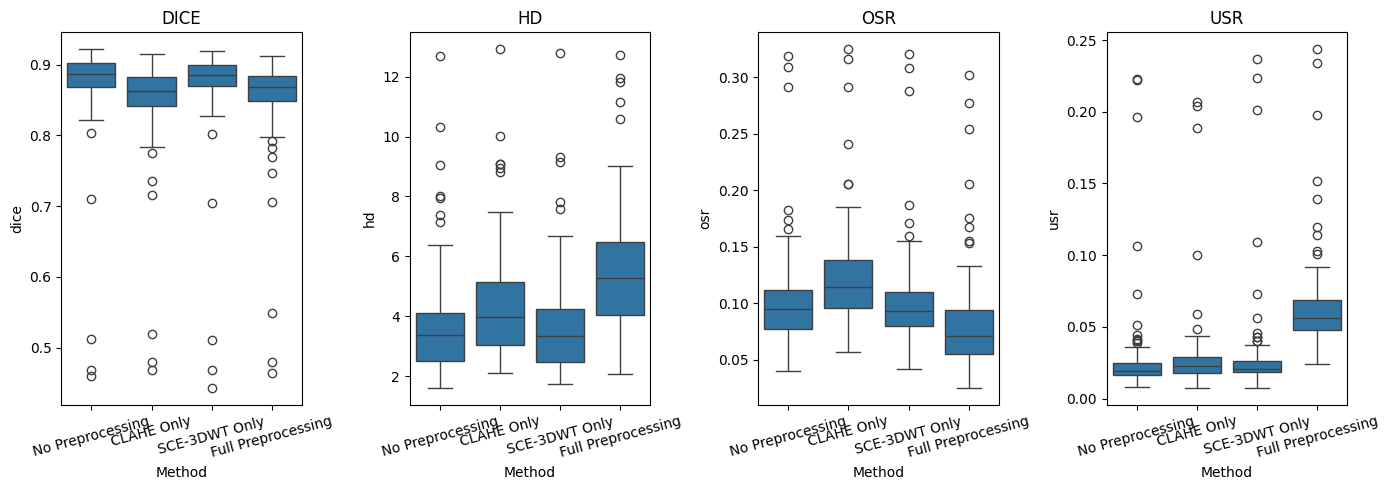

In [16]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
from segmentation import UNet3DDropoutResiduals

# --------- Update these as needed -------------
model_names = [
    ("No Preprocessing", "UNet3D_NO_PREPROCESSING"),
    ("CLAHE Only",       "UNet3D_3D_CLAHE_ONLY"),
    ("SCE-3DWT Only",    "UNet3D_SCE3DWT_ONLY"),
    ("Full Preprocessing","UNet3DdropOutResidualsV2_BCELoss")
]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_model(model_path):
    model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

results = {name: {"dice":[], "hd":[], "osr":[], "usr":[]} for name, _ in model_names}

for readable_name, model_short in model_names:
    model_path = os.path.join("models", f"{model_short}.pth")
    model = load_model(model_path)
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = torch.sigmoid(model(X_batch))
            for i in range(outputs.shape[0]):  # Should be 1, but this is general
                # Squeeze out channel dimension to get shape (D, H, W)
                pred = outputs[i].cpu().squeeze(0)
                true = y_batch[i].cpu().squeeze(0)
                results[readable_name]["dice"].append(dice_coefficient(true.unsqueeze(0), pred.unsqueeze(0)).item())
                results[readable_name]["hd"].append(hausdorff_distance(true, pred))
                results[readable_name]["osr"].append(over_segmentation_ratio(true.unsqueeze(0), pred.unsqueeze(0)).item())
                results[readable_name]["usr"].append(under_segmentation_rate(true.unsqueeze(0), pred.unsqueeze(0)).item())

# Convert to pandas DataFrame for analysis/plotting
dfs = []
for method in results:
    df_method = pd.DataFrame(results[method])
    df_method["Method"] = method
    dfs.append(df_method)
df_all = pd.concat(dfs, ignore_index=True)

# --- Statistical Test Example: Dice ---
from itertools import combinations
methods = [m[0] for m in model_names]
stat_table = []
for a, b in combinations(methods, 2):
    stat, p = wilcoxon(df_all[df_all["Method"]==a]["dice"], df_all[df_all["Method"]==b]["dice"])
    stat_table.append((a, b, p))
stat_df = pd.DataFrame(stat_table, columns=["Method A", "Method B", "Wilcoxon p-value"])
print(stat_df)

# --- Plot Boxplots for Dice, HD, OSR, USR ---
plt.figure(figsize=(14,5))
for i, metric in enumerate(["dice","hd","osr","usr"]):
    plt.subplot(1,4,i+1)
    sns.boxplot(data=df_all, x="Method", y=metric)
    plt.title(metric.upper())
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


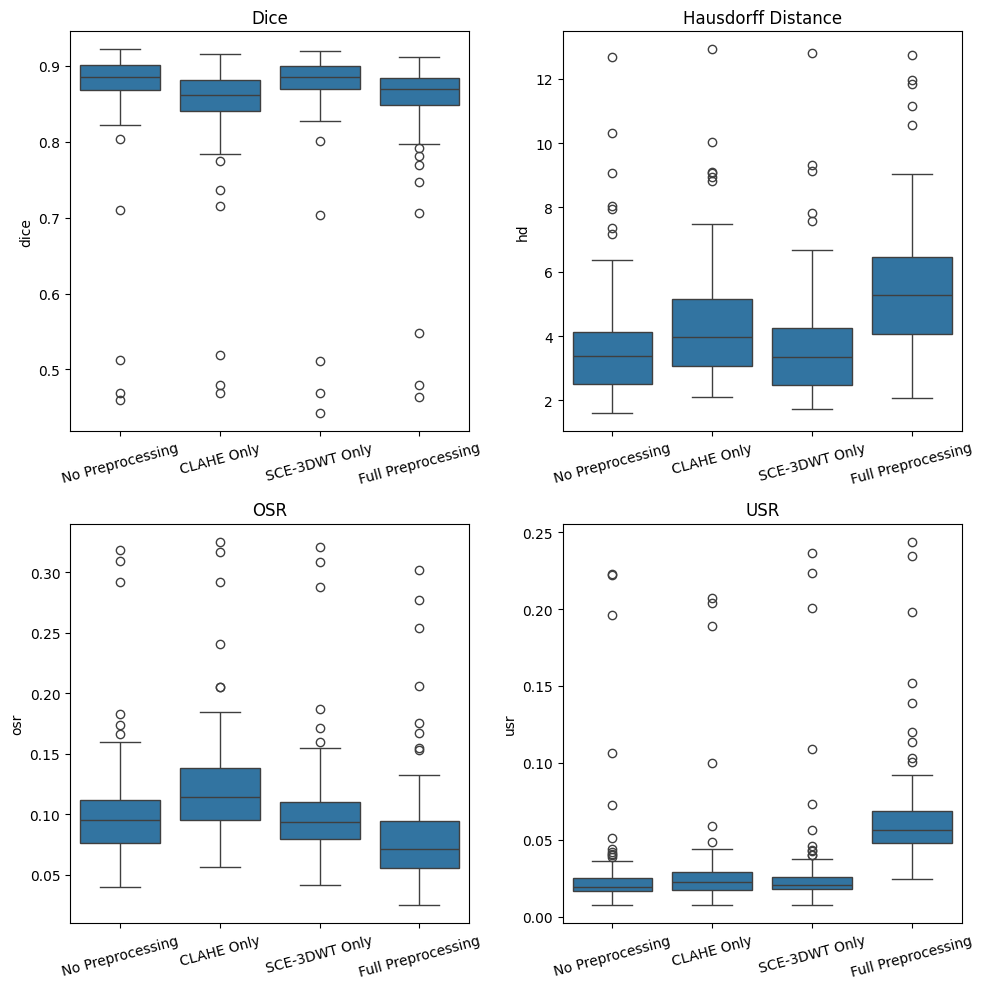

In [19]:
plt.figure(figsize=(10, 10))
metrics = ["dice", "hd", "osr", "usr"]
titles = ["Dice", "Hausdorff Distance", "OSR", "USR"]

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_all, x="Method", y=metric)
    plt.title(titles[i])
    plt.xticks(rotation=15)
    plt.xlabel("")  # Optional: cleaner axis for paper

plt.tight_layout()
plt.show()


#### all metrics

In [20]:
from itertools import combinations

metrics = ["dice", "hd", "osr", "usr"]
methods = [m[0] for m in model_names]
all_stat_tables = []

for metric in metrics:
    stat_table = []
    for a, b in combinations(methods, 2):
        values_a = df_all[df_all["Method"] == a][metric]
        values_b = df_all[df_all["Method"] == b][metric]
        stat, p = wilcoxon(values_a, values_b)
        stat_table.append((metric, a, b, p))
    all_stat_tables.extend(stat_table)

stat_df = pd.DataFrame(all_stat_tables, columns=["Metric", "Method A", "Method B", "Wilcoxon p-value"])
print(stat_df)


   Metric          Method A            Method B  Wilcoxon p-value
0    dice  No Preprocessing          CLAHE Only      2.330171e-23
1    dice  No Preprocessing       SCE-3DWT Only      3.634558e-02
2    dice  No Preprocessing  Full Preprocessing      1.188275e-18
3    dice        CLAHE Only       SCE-3DWT Only      2.209836e-22
4    dice        CLAHE Only  Full Preprocessing      1.721806e-07
5    dice     SCE-3DWT Only  Full Preprocessing      1.352990e-17
6      hd  No Preprocessing          CLAHE Only      4.285885e-07
7      hd  No Preprocessing       SCE-3DWT Only      6.227453e-01
8      hd  No Preprocessing  Full Preprocessing      3.746791e-18
9      hd        CLAHE Only       SCE-3DWT Only      8.289833e-07
10     hd        CLAHE Only  Full Preprocessing      1.086283e-13
11     hd     SCE-3DWT Only  Full Preprocessing      3.272377e-18
12    osr  No Preprocessing          CLAHE Only      6.714005e-24
13    osr  No Preprocessing       SCE-3DWT Only      5.327160e-02
14    osr 

## New Wilcoxon Tests on new models


In [1]:
import os
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Model files and associated test data
model_info = {
    "HARP_NP": {
        "pth": "NewModels/UNet3D_NP_HARP_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "HARP_FP": {
        "pth": "NewModels/UNet3D_FP_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "HARP_CLAHE": {
        "pth": "NewModels/UNet3D_3D_CLAHE_UPDATED.pth",
        "img_dir": r"D:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "MSD_NP": {
        "pth": "NewModels/MSD_NP_BINARY_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
    },
    "MSD_FP": {
        "pth": "NewModels/MSD_FP_BINARY.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
    },
    "MSD_FP_HARP":{ 
        "pth": "NewModels/Transfer_MSD_FP_to_HARP_FP.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "MSD_NP_HARP":{ 
        "pth": "NewModels/Transfer_MSD_NP_to_HARP_NP.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    }
}

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet3DDropoutResiduals(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, base_channels=32, dropout_rate=0.2):
        super(UNet3DDropoutResiduals, self).__init__()

        self.encoder_blocks = nn.ModuleList([
            self.conv_block(in_channels, base_channels, dropout_rate),
            self.conv_block(base_channels, base_channels * 2, dropout_rate),
            self.conv_block(base_channels * 2, base_channels * 4, dropout_rate),
            self.conv_block(base_channels * 4, base_channels * 8, dropout_rate),
            self.conv_block(base_channels * 8, base_channels * 16, dropout_rate)
        ])
        self.pool = nn.MaxPool3d(kernel_size=2)
        self.decoder_blocks = nn.ModuleList([
            self.upconv_block(base_channels * 16, base_channels * 8),
            self.upconv_block(base_channels * 8, base_channels * 4),
            self.upconv_block(base_channels * 4, base_channels * 2),
            self.upconv_block(base_channels * 2, base_channels)
        ])
        self.conv_after_concat = nn.ModuleList([
            self.conv_block(base_channels * 16, base_channels * 8, dropout_rate),
            self.conv_block(base_channels * 8,  base_channels * 4, dropout_rate),
            self.conv_block(base_channels * 4,  base_channels * 2, dropout_rate),
            self.conv_block(base_channels * 2,  base_channels,     dropout_rate)
        ])
        self.final_conv = nn.Conv3d(base_channels, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels, dropout_rate=0.1):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)
        )

    def forward_conv_block(self, x, block):
        out = block(x)
        if x.size() == out.size():
            out = out + x
        return out

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

    def pad_if_needed(self, x, skip):
        diffD = skip.size(2) - x.size(2)
        diffH = skip.size(3) - x.size(3)
        diffW = skip.size(4) - x.size(4)
        return F.pad(x, [diffW//2, diffW-diffW//2,
                         diffH//2, diffH-diffH//2,
                         diffD//2, diffD-diffD//2])

    def forward(self, x):
        skips = []
        for enc in self.encoder_blocks:
            x = self.forward_conv_block(x, enc)
            skips.append(x)
            x = self.pool(x)
        x = skips.pop()
        for i, dec in enumerate(self.decoder_blocks):
            skip = skips.pop()
            x = dec(x)
            x = self.pad_if_needed(x, skip)
            x = torch.cat([x, skip], dim=1)
            x = self.forward_conv_block(x, self.conv_after_concat[i])
        return self.final_conv(x)
    
    def pad_if_needed(self, x, skip):
        # Automatically pad the smaller tensor so it matches the spatial dimensions of the larger one
        diff_depth = skip.size(2) - x.size(2)
        diff_height = skip.size(3) - x.size(3)
        diff_width = skip.size(4) - x.size(4)

        x = F.pad(x, [diff_width // 2, diff_width - diff_width // 2,
                        diff_height // 2, diff_height - diff_height // 2,
                        diff_depth // 2, diff_depth - diff_depth // 2])
        return x


#### visualizing model

In [48]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
import shutil; print(shutil.which("dot"))


C:\Program Files\Graphviz\bin\dot.EXE


In [14]:
### loaders

# Dataset and DataLoader setup
class HippocampusSegmentationDataset(Dataset):
    def __init__(self, img_dir, lbl_dir):
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
        self.lbl_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
        self.img_dir = img_dir
        self.lbl_dir = lbl_dir

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img = nib.load(os.path.join(self.img_dir, self.img_files[idx])).get_fdata().astype(np.float32)
        lbl = nib.load(os.path.join(self.lbl_dir, self.lbl_files[idx])).get_fdata().astype(np.float32)
        lbl = (lbl > 0).astype(np.float32)  # binarize if needed
        return (
            torch.from_numpy(img).unsqueeze(0),  # [1, D, H, W]
            torch.from_numpy(lbl).unsqueeze(0)
        )

def get_test_loader(img_dir, lbl_dir, batch_size=1):
    ds = HippocampusSegmentationDataset(img_dir, lbl_dir)
    return DataLoader(ds, batch_size=batch_size, shuffle=False)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load models
def load_model(model_path):
    model = UNet3DDropoutResiduals(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

#### FP vs NP in same domain (Harp vs harp, MSD vs MSD)


In [34]:
import os
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from scipy.stats import wilcoxon
import pandas as pd


def evaluate_model(model, loader):
    metrics = {'dice':[], 'acc':[], 'f1':[], 'jaccard':[], 'osr':[], 'usr':[], 'hd':[], 'loss':[]}
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = torch.sigmoid(model(X_batch))
            for i in range(outputs.shape[0]):
                y_true = y_batch[i]
                y_pred = outputs[i]
                metrics['dice'].append(dice_coefficient(y_true, y_pred).item())
                metrics['acc'].append(calculate_accuracy(y_true, y_pred).item())
                metrics['f1'].append(f1_score(y_true, y_pred).item())
                metrics['jaccard'].append(jaccard_index(y_true, y_pred).item())
                metrics['osr'].append(over_segmentation_ratio(y_true, y_pred).item())
                metrics['usr'].append(under_segmentation_rate(y_true, y_pred).item())
                metrics['hd'].append(hausdorff_distance(y_true, y_pred))
                metrics['loss'].append(bce_loss(y_true, y_pred).item())
    return metrics

# --- HarP dataset analysis (FP vs NP) ---
results = {}
for name in ["HARP_NP", "HARP_FP"]:
    print(f"Evaluating {name}...")
    info = model_info[name]
    ds = HippocampusSegmentationDataset(info["img_dir"], info["lbl_dir"])
    loader = DataLoader(ds, batch_size=1, shuffle=False)
    model = load_model(info["pth"])
    metrics = evaluate_model(model, loader)
    results[name] = metrics
    print(f"{name} - Dice mean: {np.mean(metrics['dice']):.4f}, std: {np.std(metrics['dice']):.4f}")

# --- MSD dataset analysis (FP vs NP) ---
for name in ["MSD_NP", "MSD_FP"]:
    print(f"Evaluating {name}...")
    info = model_info[name]
    ds = HippocampusSegmentationDataset(info["img_dir"], info["lbl_dir"])
    loader = DataLoader(ds, batch_size=1, shuffle=False)
    model = load_model(info["pth"])
    metrics = evaluate_model(model, loader)
    results[name] = metrics
    print(f"{name} - Dice mean: {np.mean(metrics['dice']):.4f}, std: {np.std(metrics['dice']):.4f}")

# --- Statistical analysis ---
def print_stats(a, b, a_label, b_label, metric):
    a_vals = np.array(results[a][metric])
    b_vals = np.array(results[b][metric])
    stat, p = wilcoxon(a_vals, b_vals)
    print(f"Metric: {metric}")
    print(f"{a_label}: {np.mean(a_vals):.4f} ± {np.std(a_vals):.4f}")
    print(f"{b_label}: {np.mean(b_vals):.4f} ± {np.std(b_vals):.4f}")
    print(f"Wilcoxon p-value: {p:.3e} {'(significant)' if p < 0.05 else '(ns)'}")
    print("-"*45)

# HARP: NP vs FP
print("\n\n--- HarP Statistical Comparison (Test Set) ---")
for m in ['dice','acc','f1','jaccard','osr','usr','hd','loss']:
    print_stats("HARP_NP","HARP_FP","HarP NP","HarP FP",m)

# MSD: NP vs FP
print("\n\n--- MSD Statistical Comparison (Test Set) ---")
for m in ['dice','acc','f1','jaccard','osr','usr','hd','loss']:
    print_stats("MSD_NP","MSD_FP","MSD NP","MSD FP",m)

# ---- Conclusion Statement Template ----
print("\nSTATISTICAL ANALYSIS SUMMARY:")
print("For both the HarP and MSD datasets, paired Wilcoxon signed-rank tests reveal that [specify metrics: e.g., Dice, OSR, etc.] differ significantly (p < 0.05) between the Full Preprocessing and No Preprocessing pipelines. This confirms that preprocessing choices have a substantial impact on hippocampus segmentation performance, especially for [specify metric/trend], and supports the value of a balanced enhancement approach in clinical neuroimaging workflows.")



Evaluating HARP_NP...
HARP_NP - Dice mean: 0.8803, std: 0.0672
Evaluating HARP_FP...
HARP_FP - Dice mean: 0.8713, std: 0.0623
Evaluating MSD_NP...
MSD_NP - Dice mean: 0.5844, std: 0.0376
Evaluating MSD_FP...
MSD_FP - Dice mean: 0.5841, std: 0.0393


--- HarP Statistical Comparison (Test Set) ---
Metric: dice
HarP NP: 0.8803 ± 0.0672
HarP FP: 0.8713 ± 0.0623
Wilcoxon p-value: 9.068e-18 (significant)
---------------------------------------------
Metric: acc
HarP NP: 0.9967 ± 0.0019
HarP FP: 0.9964 ± 0.0018
Wilcoxon p-value: 5.953e-18 (significant)
---------------------------------------------
Metric: f1
HarP NP: 0.9253 ± 0.0311
HarP FP: 0.9195 ± 0.0295
Wilcoxon p-value: 1.236e-18 (significant)
---------------------------------------------
Metric: jaccard
HarP NP: 0.7911 ± 0.0824
HarP FP: 0.7761 ± 0.0774
Wilcoxon p-value: 1.792e-18 (significant)
---------------------------------------------
Metric: osr
HarP NP: 0.0656 ± 0.0392
HarP FP: 0.0709 ± 0.0411
Wilcoxon p-value: 1.406e-07 (signific

In [35]:
def summary_statement(metric, np_mean, fp_mean, p, higher_is_better=True):
    if p < 0.05:
        if higher_is_better:
            winner = "Full Preprocessing" if fp_mean > np_mean else "No Preprocessing"
        else:
            winner = "Full Preprocessing" if fp_mean < np_mean else "No Preprocessing"
        return f"For {metric}, {winner} performed significantly better (p={p:.2e})."
    else:
        return f"For {metric}, no significant difference was observed (p={p:.2e})."

print("\nSUMMARY OF FINDINGS:\n")
for dataset, label in [("HARP", "HarP"), ("MSD", "MSD")]:
    print(f"--- {label} Test Set ---")
    for metric, higher_is_better in [
        ('dice', True), ('acc', True), ('f1', True), ('jaccard', True),
        ('osr', False), ('usr', False), ('hd', False), ('loss', False)
    ]:
        np_vals = np.array(results[f"{dataset}_NP"][metric])
        fp_vals = np.array(results[f"{dataset}_FP"][metric])
        stat, p = wilcoxon(np_vals, fp_vals)
        np_mean = np.mean(np_vals)
        fp_mean = np.mean(fp_vals)
        print(summary_statement(metric.upper(), np_mean, fp_mean, p, higher_is_better))
    print()



SUMMARY OF FINDINGS:

--- HarP Test Set ---
For DICE, No Preprocessing performed significantly better (p=9.07e-18).
For ACC, No Preprocessing performed significantly better (p=5.95e-18).
For F1, No Preprocessing performed significantly better (p=1.24e-18).
For JACCARD, No Preprocessing performed significantly better (p=1.79e-18).
For OSR, No Preprocessing performed significantly better (p=1.41e-07).
For USR, No Preprocessing performed significantly better (p=5.51e-09).
For HD, no significant difference was observed (p=2.24e-01).
For LOSS, No Preprocessing performed significantly better (p=2.04e-19).

--- MSD Test Set ---
For DICE, no significant difference was observed (p=1.63e-01).
For ACC, No Preprocessing performed significantly better (p=1.22e-02).
For F1, no significant difference was observed (p=4.98e-01).
For JACCARD, no significant difference was observed (p=1.69e-01).
For OSR, No Preprocessing performed significantly better (p=9.25e-03).
For USR, no significant difference was

#### Transfer Learning FP vs NP

In [15]:
import os
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from scipy.stats import wilcoxon
import pandas as pd


def evaluate_model(model, loader):
    metrics = {'dice':[], 'acc':[], 'f1':[], 'jaccard':[], 'osr':[], 'usr':[], 'hd':[], 'loss':[]}
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = torch.sigmoid(model(X_batch))
            for i in range(outputs.shape[0]):
                y_true = y_batch[i]
                y_pred = outputs[i]
                metrics['dice'].append(dice_coefficient(y_true, y_pred).item())
                metrics['acc'].append(calculate_accuracy(y_true, y_pred).item())
                metrics['f1'].append(f1_score(y_true, y_pred).item())
                metrics['jaccard'].append(jaccard_index(y_true, y_pred).item())
                metrics['osr'].append(over_segmentation_ratio(y_true, y_pred).item())
                metrics['usr'].append(under_segmentation_rate(y_true, y_pred).item())
                metrics['hd'].append(hausdorff_distance(y_true, y_pred))
                metrics['loss'].append(bce_loss(y_true, y_pred).item())
    return metrics

# --- HarP dataset analysis (FP vs NP) ---
results = {}
for name in ["MSD_FP_HARP", "MSD_NP_HARP"]:
    print(f"Evaluating {name}...")
    info = model_info[name]
    ds = HippocampusSegmentationDataset(info["img_dir"], info["lbl_dir"])
    loader = DataLoader(ds, batch_size=1, shuffle=False)
    model = load_model(info["pth"])
    metrics = evaluate_model(model, loader)
    results[name] = metrics
    print(f"{name} - Dice mean: {np.mean(metrics['dice']):.4f}, std: {np.std(metrics['dice']):.4f}")


# --- Statistical analysis ---
def print_stats(a, b, a_label, b_label, metric):
    a_vals = np.array(results[a][metric])
    b_vals = np.array(results[b][metric])
    stat, p = wilcoxon(a_vals, b_vals)
    print(f"Metric: {metric}")
    print(f"{a_label}: {np.mean(a_vals):.4f} ± {np.std(a_vals):.4f}")
    print(f"{b_label}: {np.mean(b_vals):.4f} ± {np.std(b_vals):.4f}")
    print(f"Wilcoxon p-value: {p:.3e} {'(significant)' if p < 0.05 else '(ns)'}")
    print("-"*45)

# HARP: NP vs FP
print("\n\n--- HarP Statistical Comparison (Test Set) ---")
for m in ['dice','acc','f1','jaccard','osr','usr','hd','loss']:
    print_stats("MSD_NP_HARP","MSD_FP_HARP","Transfered on NP","Transfered on FP",m)


# ---- Conclusion Statement Template ----
print("\nSTATISTICAL ANALYSIS SUMMARY:")
print("For both the HarP and MSD datasets, paired Wilcoxon signed-rank tests reveal that [specify metrics: e.g., Dice, OSR, etc.] differ significantly (p < 0.05) between the Full Preprocessing and No Preprocessing pipelines. This confirms that preprocessing choices have a substantial impact on hippocampus segmentation performance, especially for [specify metric/trend], and supports the value of a balanced enhancement approach in clinical neuroimaging workflows.")



Evaluating MSD_FP_HARP...
MSD_FP_HARP - Dice mean: 0.8705, std: 0.0627
Evaluating MSD_NP_HARP...
MSD_NP_HARP - Dice mean: 0.8764, std: 0.0668


--- HarP Statistical Comparison (Test Set) ---
Metric: dice
Transfered on NP: 0.8764 ± 0.0668
Transfered on FP: 0.8705 ± 0.0627
Wilcoxon p-value: 4.985e-13 (significant)
---------------------------------------------
Metric: acc
Transfered on NP: 0.9966 ± 0.0019
Transfered on FP: 0.9964 ± 0.0018
Wilcoxon p-value: 1.048e-11 (significant)
---------------------------------------------
Metric: f1
Transfered on NP: 0.9229 ± 0.0308
Transfered on FP: 0.9191 ± 0.0297
Wilcoxon p-value: 1.538e-13 (significant)
---------------------------------------------
Metric: jaccard
Transfered on NP: 0.7848 ± 0.0817
Transfered on FP: 0.7750 ± 0.0778
Wilcoxon p-value: 2.823e-13 (significant)
---------------------------------------------
Metric: osr
Transfered on NP: 0.0703 ± 0.0393
Transfered on FP: 0.0733 ± 0.0410
Wilcoxon p-value: 7.670e-03 (significant)
-----------

### Visual Comparison


Label shape (X, Y, Z): (43, 59, 47)


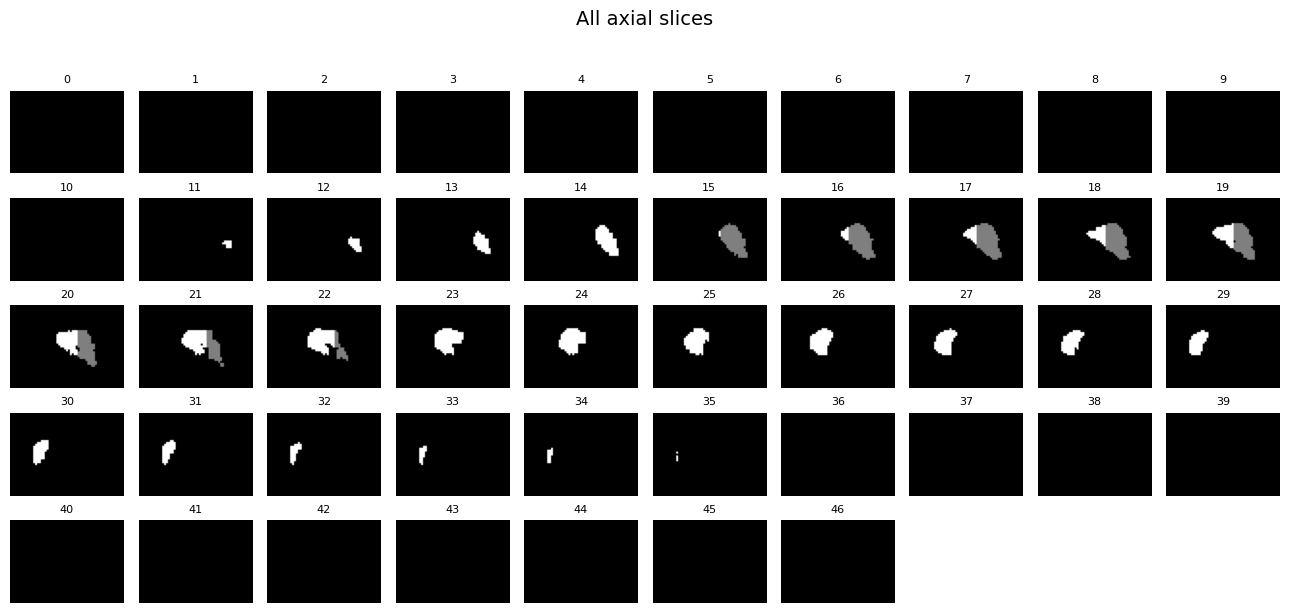

Saved: label_axial.png


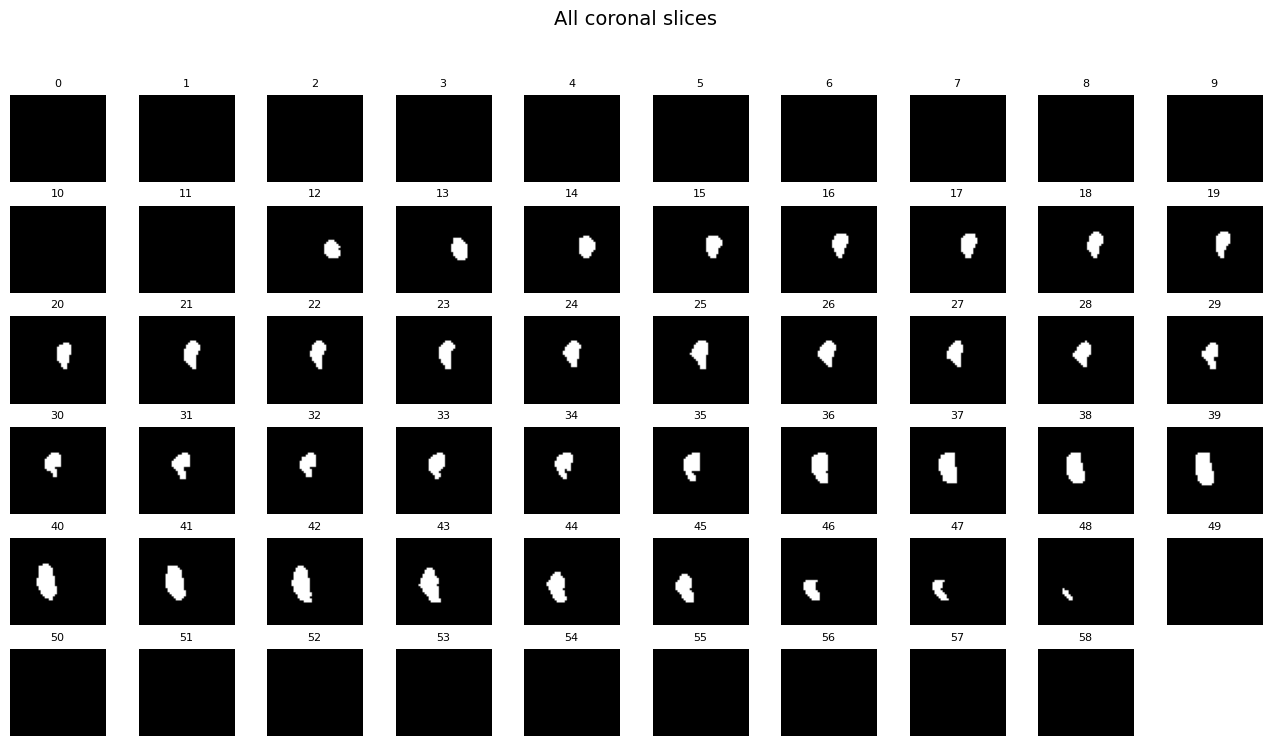

Saved: label_coronal.png


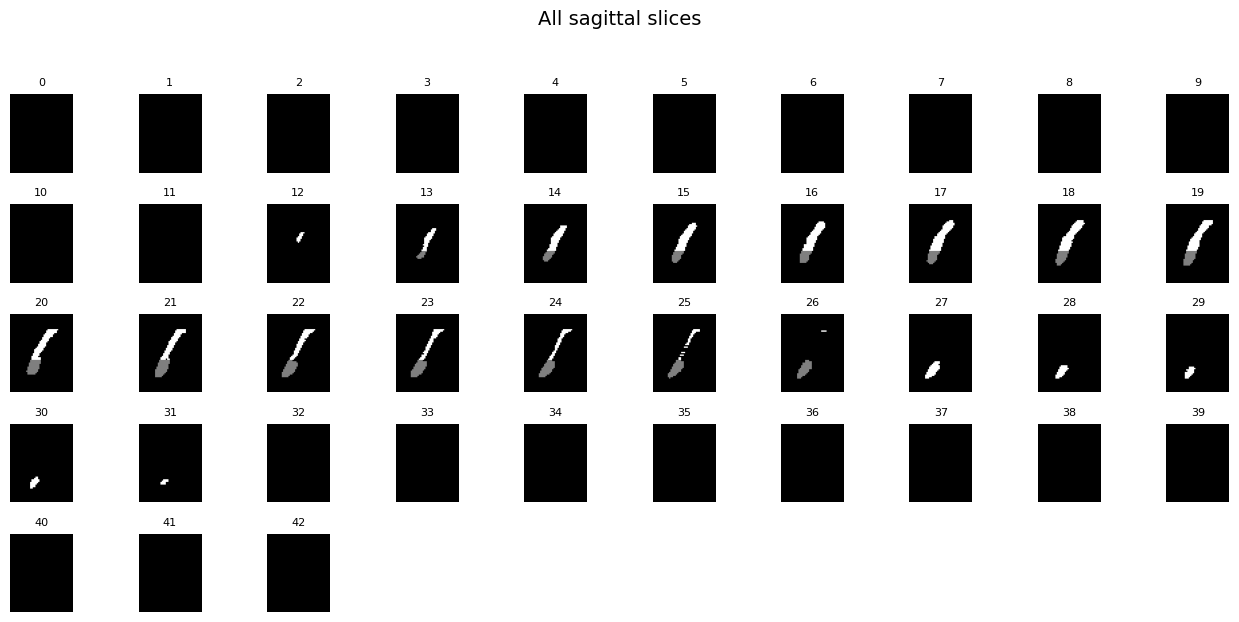

Saved: label_sagittal.png


In [26]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Path to your label folder
lbl_dir = r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"

# Get the first label file
label_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
if not label_files:
    raise RuntimeError("No label files found!")
label_path = os.path.join(lbl_dir, label_files[0])

# Load label
lbl_3d = nib.load(label_path).get_fdata().astype(np.float32)
print("Label shape (X, Y, Z):", lbl_3d.shape)

# Function to plot all slices along a given axis
def plot_all_slices(data, axis=2, slices_per_row=10, outname='slices.png', cmap='gray', axis_name='axial'):
    # Move desired axis to the last position for easy slicing
    data = np.moveaxis(data, axis, -1)
    num_slices = data.shape[-1]
    num_rows = int(np.ceil(num_slices / slices_per_row))
    plt.figure(figsize=(slices_per_row * 1.3, num_rows * 1.3))
    for i in range(num_slices):
        plt.subplot(num_rows, slices_per_row, i+1)
        plt.imshow(data[..., i], cmap=cmap)
        plt.axis('off')
        plt.title(str(i), fontsize=8)
    plt.suptitle(f'All {axis_name} slices', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(outname, dpi=200)
    plt.show()
    print(f"Saved: {outname}")

# Plot all slices along each axis
plot_all_slices(lbl_3d, axis=2, slices_per_row=10, outname='label_axial.png', axis_name='axial')       # Axial: Z
plot_all_slices(lbl_3d, axis=1, slices_per_row=10, outname='label_coronal.png', axis_name='coronal')   # Coronal: Y
plot_all_slices(lbl_3d, axis=0, slices_per_row=10, outname='label_sagittal.png', axis_name='sagittal') # Sagittal: X


Processing: HARP_NP_vs_HARP_FP
slice_num 32


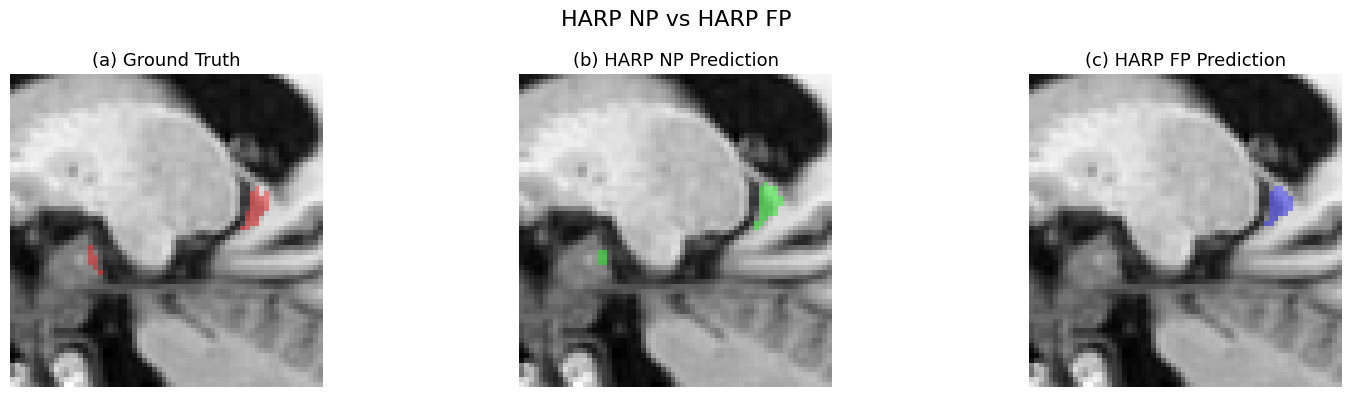

Processing: MSD_NP_vs_MSD_FP
slice_num 23


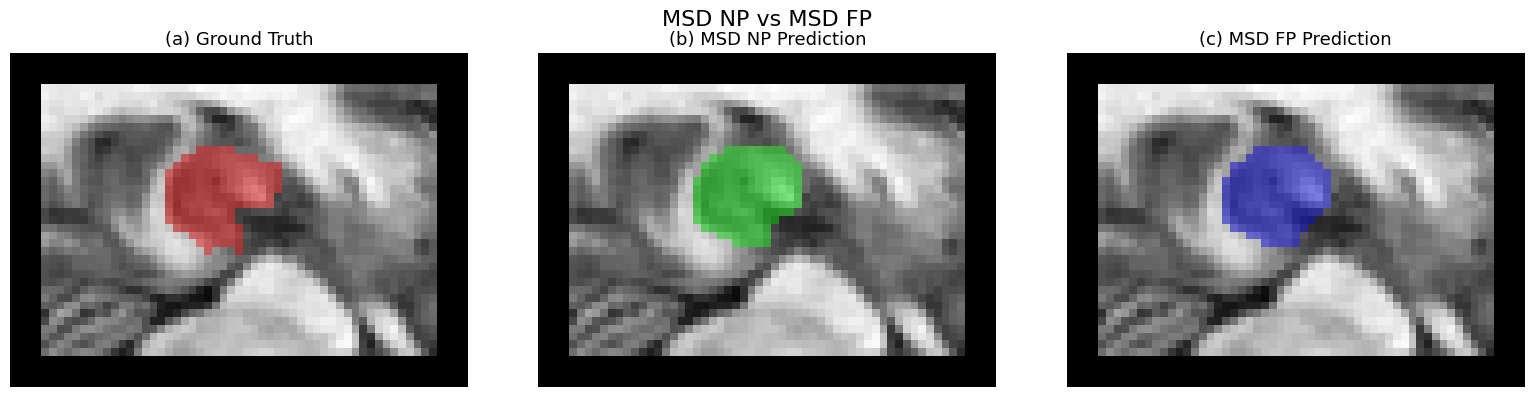

Processing: MSD_FP_HARP_vs_MSD_NP_HARP
slice_num 32


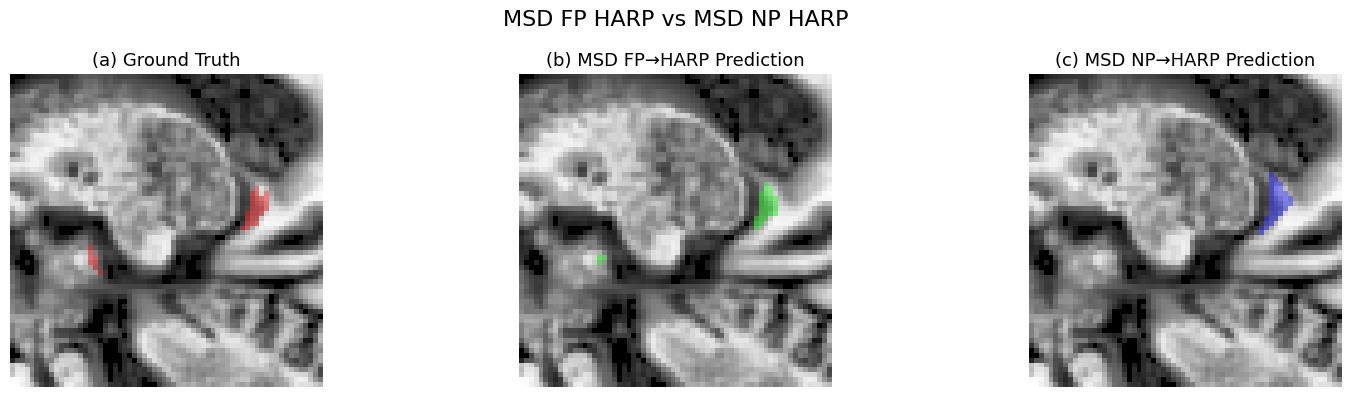

Done! Change 'slice_num' as needed for different anatomical levels.


In [6]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# ==================================
#       CONFIGURATION
# ==================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Model loading utility ----
def load_model(model_class, ckpt_path):
    # Always match checkpoint! (in_channels=1, out_channels=1)
    model = model_class(in_channels=1, out_channels=1)
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

# ---- Nifti image utility ----
def load_nifti(fp):
    return nib.load(fp).get_fdata().astype(np.float32)

# ---- Overlay helper ----
def overlay_mask_on_slice(img2d, mask2d, color=(1,0,0), alpha=0.35):
    img2d_norm = (img2d - np.min(img2d)) / (np.max(img2d) - np.min(img2d) + 1e-7)
    rgb = np.stack([img2d_norm]*3, axis=-1)
    mask = mask2d.astype(bool)
    overlay = rgb.copy()
    overlay[mask, 0] = (1 - alpha) * rgb[mask, 0] + alpha * color[0]
    overlay[mask, 1] = (1 - alpha) * rgb[mask, 1] + alpha * color[1]
    overlay[mask, 2] = (1 - alpha) * rgb[mask, 2] + alpha * color[2]
    return overlay

# ---- Visualization function ----
def plot_comparison_row(mri, gt, pred1, pred2, slice_idx, titles, suptitle=None, save_path=None):
    plt.figure(figsize=(16, 4))
    for i, (data, title, color) in enumerate(zip(
            [gt, pred1, pred2],
            titles,
            [(1,0,0), (0,1,0), (0,0,1)])):
        mask_overlay = overlay_mask_on_slice(mri, data, color=color, alpha=0.4)
        plt.subplot(1, 3, i+1)
        plt.imshow(mask_overlay)
        plt.title(f'({chr(97+i)}) {title}', fontsize=13)
        plt.axis('off')
    if suptitle:
        plt.suptitle(suptitle, fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

# ==================================
#    YOUR MODEL/FILE LOCATIONS
# ==================================

# Model files and associated test data
model_info = {
    "HARP_NP": {
        "pth": "NewModels/UNet3D_NP_HARP_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "HARP_FP": {
        "pth": "NewModels/UNet3D_FP_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "HARP_CLAHE": {
        "pth": "NewModels/UNet3D_3D_CLAHE_UPDATED.pth",
        "img_dir": r"D:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "MSD_NP": {
        "pth": "NewModels/MSD_NP_BINARY_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
    },
    "MSD_FP": {
        "pth": "NewModels/MSD_FP_BINARY.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
    },
    "MSD_FP_HARP":{ 
        "pth": "NewModels/Transfer_MSD_FP_to_HARP_FP.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "MSD_NP_HARP":{ 
        "pth": "NewModels/Transfer_MSD_NP_to_HARP_NP.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    }
}
# ---- Import your model class here
# from my_models import UNet3DDropoutResiduals   # Uncomment and use your import!
UNet3D = UNet3DDropoutResiduals   # Keep this as your model CLASS

# ==================================
#    SLICE SELECTION
# ==================================
slice_num = 48  # <--- Change this as needed (axial slice, for 64x64x96 data, 0-95)

# ==================================
#   DATA LOADING FUNCTION
# ==================================
def get_sample_paths(img_dir, lbl_dir):
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    lbl_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    files = sorted(list(set(img_files) & set(lbl_files)))
    return [os.path.join(img_dir, files[0]), os.path.join(lbl_dir, files[0])] # Pick the first common subject

def run_inference(model, image_3d):
    inp = torch.from_numpy(image_3d[None, None, ...]).float().to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(inp)).cpu().numpy()[0,0]  # Shape: D,H,W
    return (pred > 0.5).astype(np.uint8)  # Binary mask

# ==================================
#  VISUAL COMPARISON: EXAMPLES
# ==================================
comparisons = [
    {
        "name": "HARP_NP_vs_HARP_FP",
        "models": ["HARP_NP", "HARP_FP"],
        "titles": ["Ground Truth", "HARP NP Prediction", "HARP FP Prediction"],
        "img_dir": model_info["HARP_NP"]["img_dir"],
        "lbl_dir": model_info["HARP_NP"]["lbl_dir"],
    },
    {
        "name": "MSD_NP_vs_MSD_FP",
        "models": ["MSD_NP", "MSD_FP"],
        "titles": ["Ground Truth", "MSD NP Prediction", "MSD FP Prediction"],
        "img_dir": model_info["MSD_NP"]["img_dir"],
        "lbl_dir": model_info["MSD_NP"]["lbl_dir"],
    },
    {
        "name": "MSD_FP_HARP_vs_MSD_NP_HARP",
        "models": ["MSD_FP_HARP", "MSD_NP_HARP"],
        "titles": ["Ground Truth", "MSD FP→HARP Prediction", "MSD NP→HARP Prediction"],
        "img_dir": model_info["MSD_FP_HARP"]["img_dir"],
        "lbl_dir": model_info["MSD_FP_HARP"]["lbl_dir"],
    },
]

for comp in comparisons:
    print(f"Processing: {comp['name']}")
    img_path, lbl_path = get_sample_paths(comp['img_dir'], comp['lbl_dir'])
    img_3d = load_nifti(img_path)
    lbl_3d = load_nifti(lbl_path)
    img_3d = (img_3d - np.min(img_3d)) / (np.max(img_3d) - np.min(img_3d) + 1e-7)
    modelA = load_model(UNet3D, model_info[comp["models"][0]]["pth"])
    modelB = load_model(UNet3D, model_info[comp["models"][1]]["pth"])
    predA = run_inference(modelA, img_3d)
    predB = run_inference(modelB, img_3d)
    # Find a slice with visible segmentation

    if "HARP" in comp['name']:
        slice_num = 32 if 32 < img_3d.shape[2] else img_3d.shape[2] // 2
    else:
        slice_num=25
        nonempty_slices = [i for i in range(img_3d.shape[2]) if lbl_3d[:, :, i].sum() > 0]
        if not nonempty_slices:
            # If no label present, pick 21 if in bounds, else 33 if in bounds, else center
            if img_3d.shape[2] > 21:
                slice_num = 21
            elif img_3d.shape[2] > 25:
                slice_num = 25
            else:
                slice_num = img_3d.shape[2] // 2
        else:
            # Pick central nonempty mask slice
            slice_num = nonempty_slices[len(nonempty_slices)//2]
    
    print('slice_num',slice_num)
    mri_slice = img_3d[:, :, slice_num]
    gt_slice = lbl_3d[:, :, slice_num]
    predA_slice = predA[:, :, slice_num]
    predB_slice = predB[:, :, slice_num]

    plot_comparison_row(
        mri_slice,
        gt_slice,
        predA_slice,
        predB_slice,
        slice_idx=slice_num,
        titles=comp["titles"],
        suptitle=comp["name"].replace("_", " "),
        save_path=f"300dpi{comp['name']}_slice{slice_num}.png"
    )

print("Done! Change 'slice_num' as needed for different anatomical levels.")


#### 300 dpi

Processing: MSD_NP_vs_MSD_FP
slice_num 23


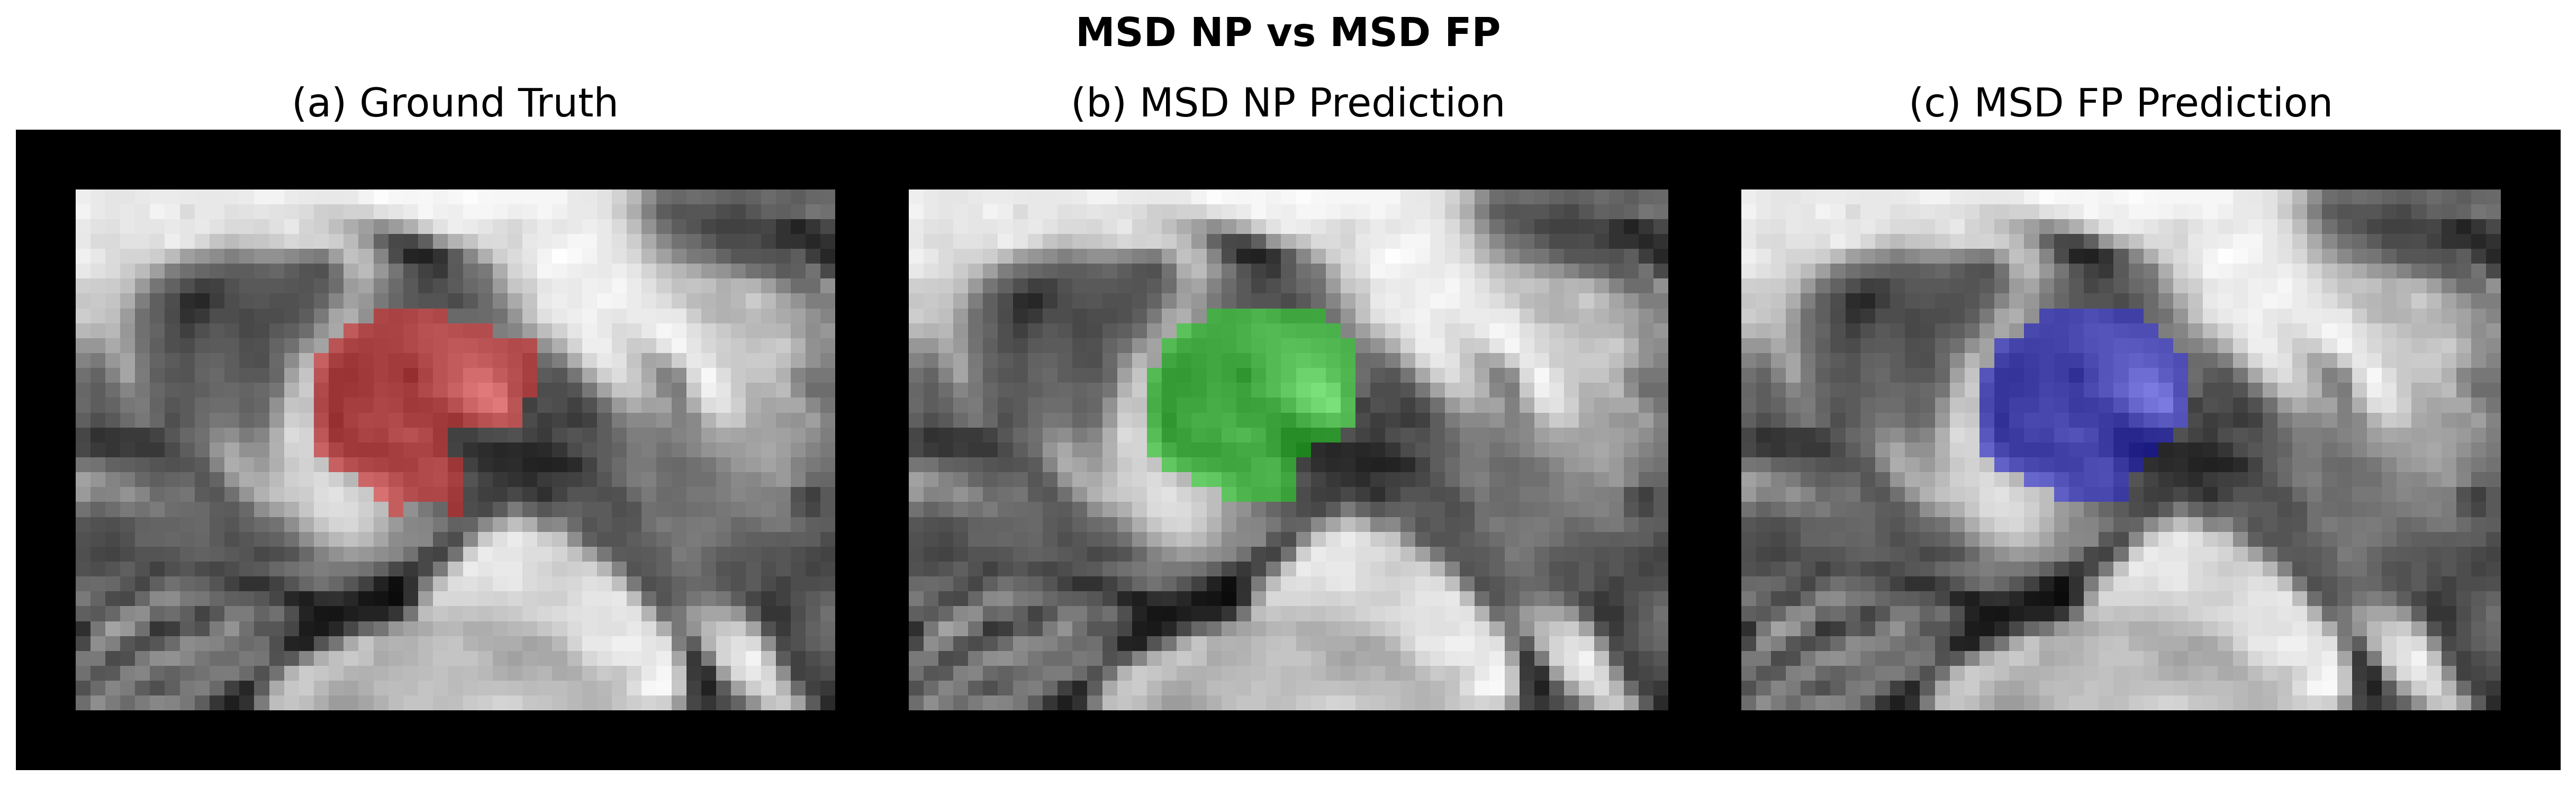

Processing: MSD_FP_HARP_vs_MSD_NP_HARP
slice_num 32


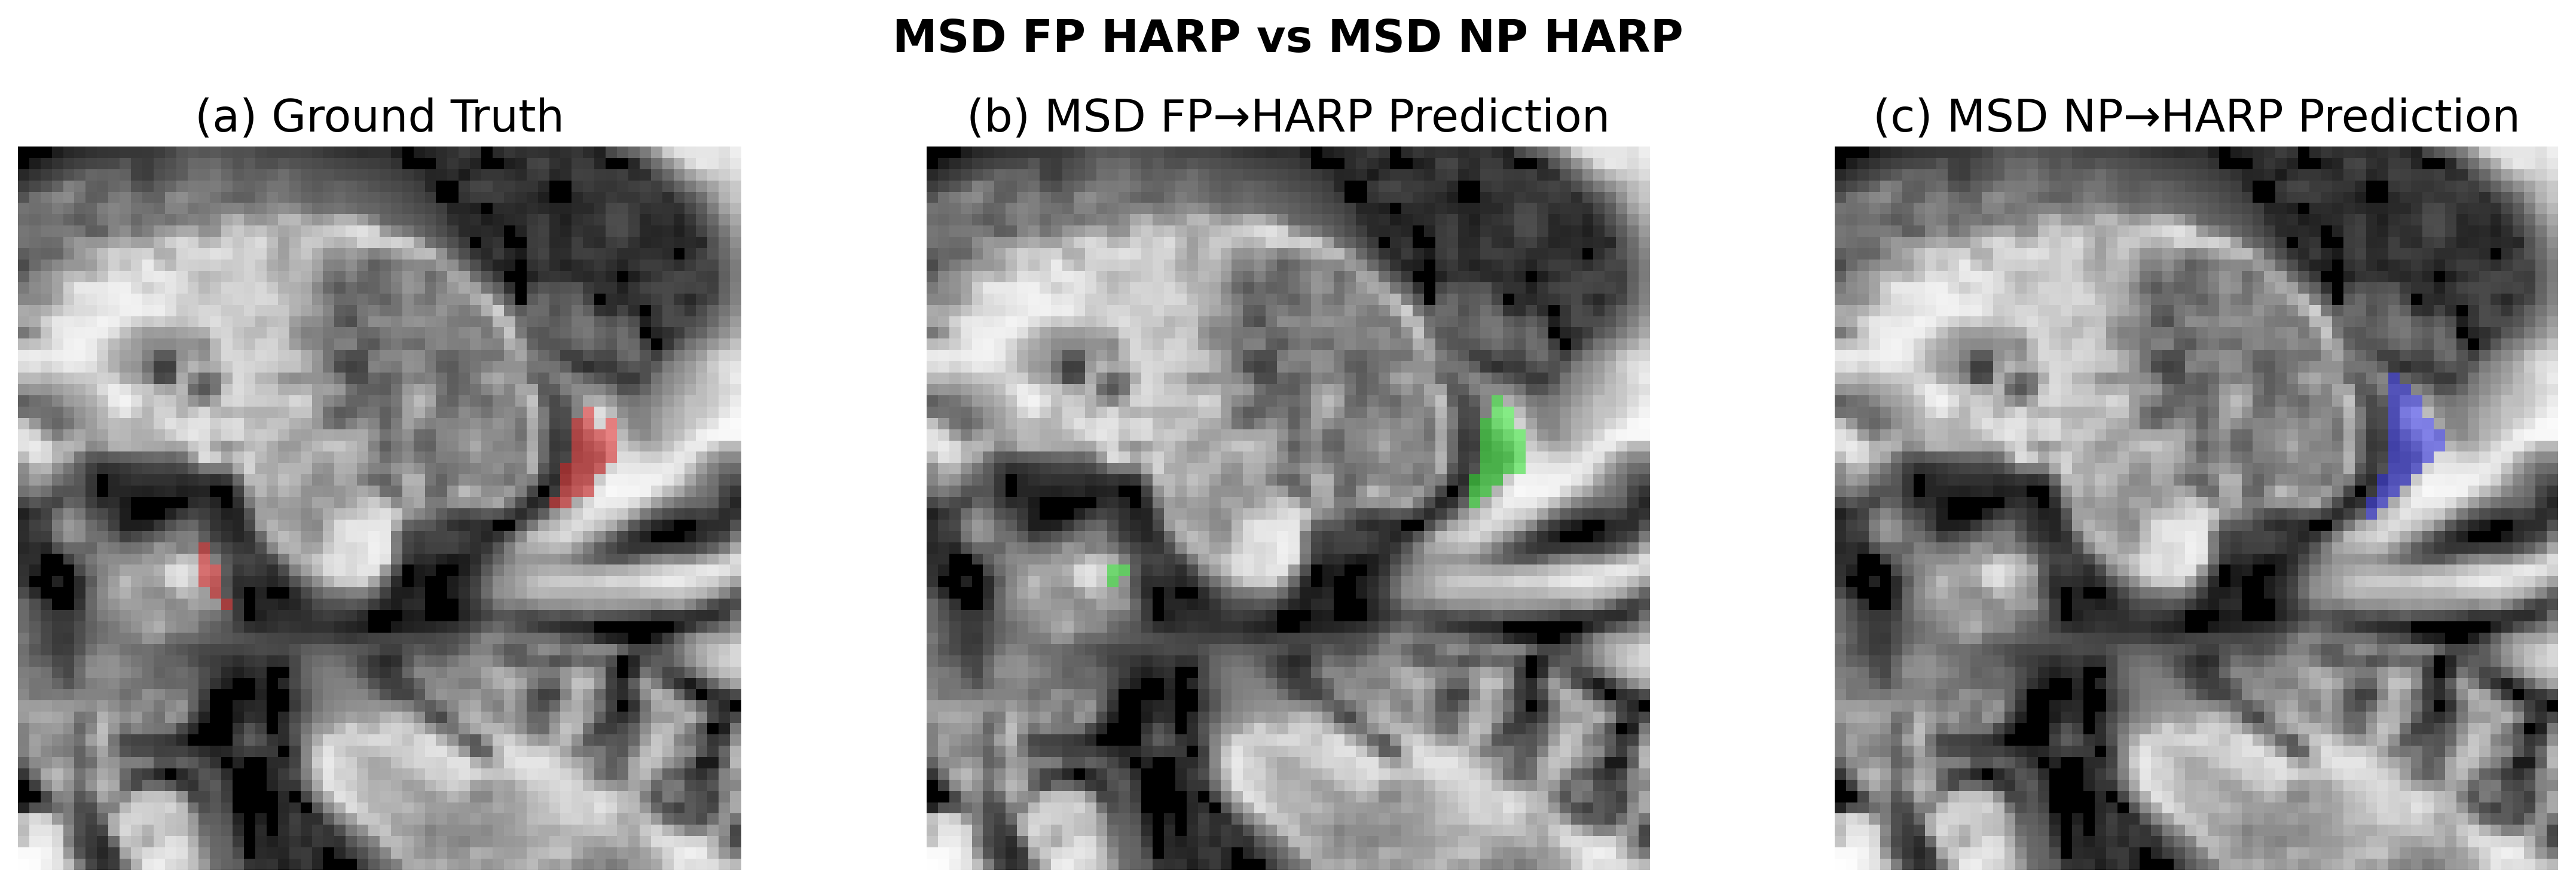

Done! Change 'slice_num' as needed for different anatomical levels.


In [19]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# ==================================
#       CONFIGURATION
# ==================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Model loading utility ----
def load_model(model_class, ckpt_path):
    model = model_class(in_channels=1, out_channels=1)
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

# ---- Nifti image utility ----
def load_nifti(fp):
    return nib.load(fp).get_fdata().astype(np.float32)

# ---- Overlay helper ----
def overlay_mask_on_slice(img2d, mask2d, color=(1,0,0), alpha=0.35):
    img2d_norm = (img2d - np.min(img2d)) / (np.max(img2d) - np.min(img2d) + 1e-7)
    rgb = np.stack([img2d_norm]*3, axis=-1)
    mask = mask2d.astype(bool)
    overlay = rgb.copy()
    overlay[mask, 0] = (1 - alpha) * rgb[mask, 0] + alpha * color[0]
    overlay[mask, 1] = (1 - alpha) * rgb[mask, 1] + alpha * color[1]
    overlay[mask, 2] = (1 - alpha) * rgb[mask, 2] + alpha * color[2]
    return overlay

# ---- Visualization function ----
def plot_comparison_row(mri, gt, pred1, pred2, slice_idx, titles, suptitle=None, save_path=r'D:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\saved_plots'):
    plt.figure(figsize=(18, 5), dpi=300)  # Increased figure size + DPI
    for i, (data, title, color) in enumerate(zip(
            [gt, pred1, pred2],
            titles,
            [(1,0,0), (0,1,0), (0,0,1)])):
        mask_overlay = overlay_mask_on_slice(mri, data, color=color, alpha=0.4)
        ax = plt.subplot(1, 3, i+1)
        ax.imshow(mask_overlay)
        ax.set_title(f'({chr(97+i)}) {title}', fontsize=18)
        ax.axis('off')
    if suptitle:
        plt.suptitle(suptitle, fontsize=18, weight='bold')
        plt.subplots_adjust(top=0.4)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")  # Export at 300 DPI
    plt.show()

# ==================================
#    YOUR MODEL/FILE LOCATIONS
# ==================================
model_info = {
    "HARP_NP": {
        "pth": "NewModels/UNet3D_NP_HARP_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "HARP_FP": {
        "pth": "NewModels/UNet3D_FP_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "HARP_CLAHE": {
        "pth": "NewModels/UNet3D_3D_CLAHE_UPDATED.pth",
        "img_dir": r"D:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D\3DCLAHE_PREPROCESSED",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "MSD_NP": {
        "pth": "NewModels/MSD_NP_BINARY_UPDATED.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\imagesTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
    },
    "MSD_FP": {
        "pth": "NewModels/MSD_FP_BINARY.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\Preprocessed\FP_PREPROCESSED",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\MSD Dataset\Task04_Hippocampus\Processed\labelsTr"
    },
    "MSD_FP_HARP":{ 
        "pth": "NewModels/Transfer_MSD_FP_to_HARP_FP.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_Harp_Preprocessed",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    },
    "MSD_NP_HARP":{ 
        "pth": "NewModels/Transfer_MSD_NP_to_HARP_NP.pth",
        "img_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\imageTr",
        "lbl_dir": r"D:\Faizaan\AlzhimersData\ADNI\HippoCampus_labels_data\Task520_HarP\labelTr"
    }
}

# ---- Import your model class here
# from my_models import UNet3DDropoutResiduals
UNet3D = UNet3DDropoutResiduals   # Model CLASS
base_dir = r"D:\Faizaan\1_DATA_PROJECTS\Projects\SegmentationUnet3D"
# ==================================
#   DATA LOADING FUNCTION
# ==================================
def get_sample_paths(img_dir, lbl_dir):
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    lbl_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    files = sorted(list(set(img_files) & set(lbl_files)))
    return [os.path.join(img_dir, files[0]), os.path.join(lbl_dir, files[0])]

def run_inference(model, image_3d):
    inp = torch.from_numpy(image_3d[None, None, ...]).float().to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(inp)).cpu().numpy()[0,0]
    return (pred > 0.5).astype(np.uint8)

# ==================================
#  VISUAL COMPARISON: EXAMPLES
# ==================================
comparisons = [
    {
        "name": "MSD_NP_vs_MSD_FP",
        "models": ["MSD_NP", "MSD_FP"],
        "titles": ["Ground Truth", "MSD NP Prediction", "MSD FP Prediction"],
        "img_dir": model_info["MSD_NP"]["img_dir"],
        "lbl_dir": model_info["MSD_NP"]["lbl_dir"],
    },
    {
        "name": "MSD_FP_HARP_vs_MSD_NP_HARP",
        "models": ["MSD_FP_HARP", "MSD_NP_HARP"],
        "titles": ["Ground Truth", "MSD FP→HARP Prediction", "MSD NP→HARP Prediction"],
        "img_dir": model_info["MSD_FP_HARP"]["img_dir"],
        "lbl_dir": model_info["MSD_FP_HARP"]["lbl_dir"],
    },
]

for comp in comparisons:
    print(f"Processing: {comp['name']}")
    img_path, lbl_path = get_sample_paths(comp['img_dir'], comp['lbl_dir'])
    img_3d = load_nifti(img_path)
    lbl_3d = load_nifti(lbl_path)
    img_3d = (img_3d - np.min(img_3d)) / (np.max(img_3d) - np.min(img_3d) + 1e-7)
    modelA = load_model(UNet3D, model_info[comp["models"][0]]["pth"])
    modelB = load_model(UNet3D, model_info[comp["models"][1]]["pth"])
    predA = run_inference(modelA, img_3d)
    predB = run_inference(modelB, img_3d)
    # Find a slice with visible segmentation

    if "HARP" in comp['name']:
        slice_num = 32 if 32 < img_3d.shape[2] else img_3d.shape[2] // 2
    else:
        slice_num=25
        nonempty_slices = [i for i in range(img_3d.shape[2]) if lbl_3d[:, :, i].sum() > 0]
        if not nonempty_slices:
            # If no label present, pick 21 if in bounds, else 33 if in bounds, else center
            if img_3d.shape[2] > 21:
                slice_num = 21
            elif img_3d.shape[2] > 25:
                slice_num = 25
            else:
                slice_num = img_3d.shape[2] // 2
        else:
            # Pick central nonempty mask slice
            slice_num = nonempty_slices[len(nonempty_slices)//2]
    
    print('slice_num',slice_num)
    mri_slice = img_3d[:, :, slice_num]
    gt_slice = lbl_3d[:, :, slice_num]
    predA_slice = predA[:, :, slice_num]
    predB_slice = predB[:, :, slice_num]

    plot_comparison_row(
        mri_slice,
        gt_slice,
        predA_slice,
        predB_slice,
        slice_idx=slice_num,
        titles=comp["titles"],
        suptitle=comp["name"].replace("_", " "),
        save_path=os.path.join(base_dir, "qualitative_results", f"300dpi{comp['name']}_slice{slice_num}.png")
    )

print("Done! Change 'slice_num' as needed for different anatomical levels.")

